In [2]:
pip install pykrx

Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5

In [84]:
from pykrx import stock

tickers = stock.get_market_ticker_list("20220101", market="KOSPI")
name = stock.get_market_ticker_name("035720")
ohlcv = stock.get_market_ohlcv("20220101", market="KOSPI")
ohlcv2 = stock.get_market_ohlcv("20140101", "20230921", "035720")

In [85]:
ohlcv2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2395 entries, 2014-01-02 to 2023-09-21
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가      2395 non-null   int32  
 1   고가      2395 non-null   int32  
 2   저가      2395 non-null   int32  
 3   종가      2395 non-null   int32  
 4   거래량     2395 non-null   int32  
 5   등락률     2395 non-null   float64
dtypes: float64(1), int32(5)
memory usage: 84.2 KB


In [86]:
# 데이터 확인하기
import pandas as pd
print(ohlcv2['고가'])

날짜
2014-01-02    17220
2014-01-03    17200
2014-01-06    17140
2014-01-07    17321
2014-01-08    17501
              ...  
2023-09-15    48900
2023-09-18    49200
2023-09-19    48700
2023-09-20    47950
2023-09-21    47150
Name: 고가, Length: 2395, dtype: int32


In [87]:
#datetime으로 변환
ohlcv2.index = pd.to_datetime(ohlcv2.index)
ohlcv2.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2023-09-08', '2023-09-11', '2023-09-12', '2023-09-13',
               '2023-09-14', '2023-09-15', '2023-09-18', '2023-09-19',
               '2023-09-20', '2023-09-21'],
              dtype='datetime64[ns]', name='날짜', length=2395, freq=None)

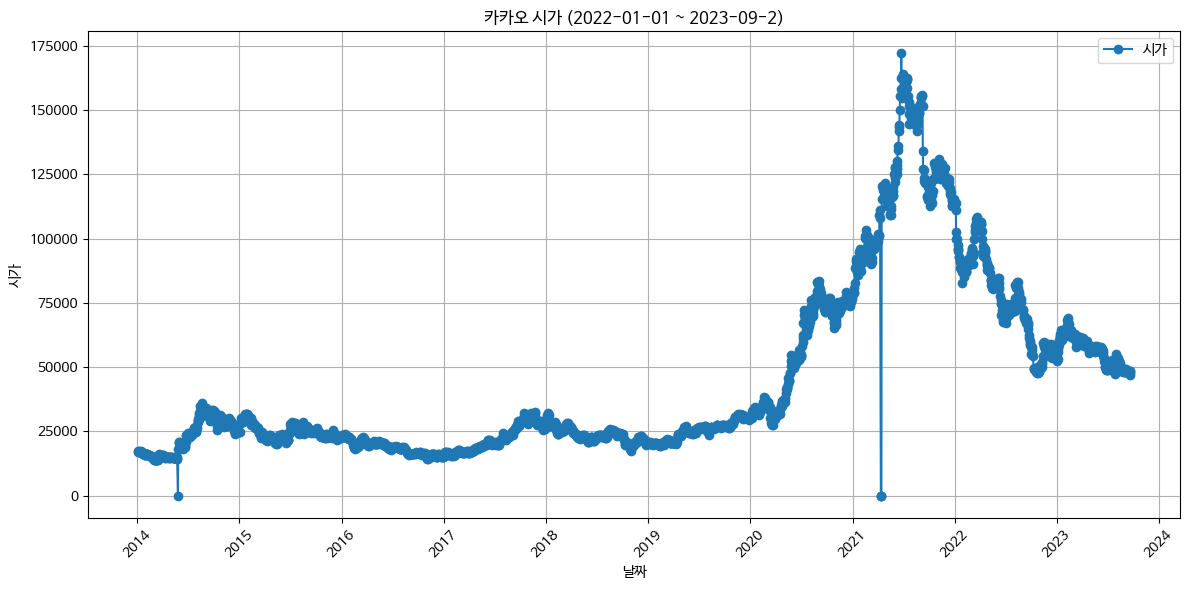

In [88]:
#데이터 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(ohlcv2.index, ohlcv2['시가'], label='시가', marker='o', linestyle='-')
plt.xlabel('날짜')
plt.ylabel('시가')
plt.title('카카오 시가 (2022-01-01 ~ 2023-09-2)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [90]:
#train 데이터와 test 데이터 분리
#train 데이터
odd_dates_data = ohlcv2[ohlcv2.index.day % 2 == 1]

#test data
even_dates_data = ohlcv2[ohlcv2.index.day % 2 ==0]
print(even_dates_data['시가'])

날짜
2014-01-02    17019
2014-01-06    17140
2014-01-08    17220
2014-01-10    16899
2014-01-14    17100
              ...  
2023-09-08    48650
2023-09-12    48200
2023-09-14    47850
2023-09-18    48550
2023-09-20    47850
Name: 시가, Length: 1195, dtype: int32


In [91]:
#랜덤 포레스트 모델
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd

#특성과 타겟 데이터 추출
X = odd_dates_data.index.values.reshape(-1, 1) #입력 데이터 2D배열로 reshape
Y = odd_dates_data['시가']

#랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(n_estimators=100)

#모델 훈련
rf_model.fit(X, Y)

#테스트 데이터를 2D 배열로 reshape
test_dates = even_dates_data.index.values.reshape(-1, 1)
                                                 
#테스트 세트로 예측
y_pred = rf_model.predict(test_dates)

#결과 출력
print('정확도: ', metrics.accuracy_score(even_dates_data['시가'], y_pred))

prediction_date = pd.to_datetime("2023-09-25").timestamp()
predicted_price = rf_model.predict([[prediction_date]])[0]

print(f"2023-09-25의 예상 시가: {predicted_price:.2f} 원")

정확도:  0.024267782426778243
2023-09-25의 예상 시가: 17200.00 원


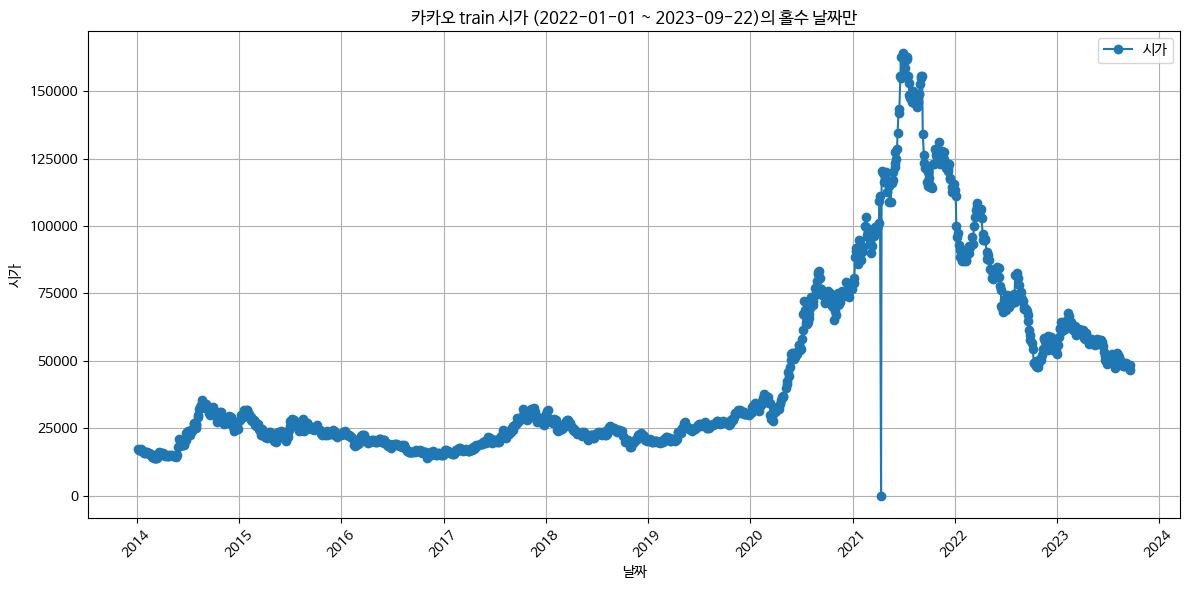

In [92]:
#랜덤 포레스트 모델 그래프
#train
plt.figure(figsize=(12, 6))
plt.plot(odd_dates_data.index, odd_dates_data['시가'], label='시가', marker='o', linestyle='-')
plt.xlabel('날짜')
plt.ylabel('시가')
plt.title('카카오 train 시가 (2022-01-01 ~ 2023-09-22)의 홀수 날짜만')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

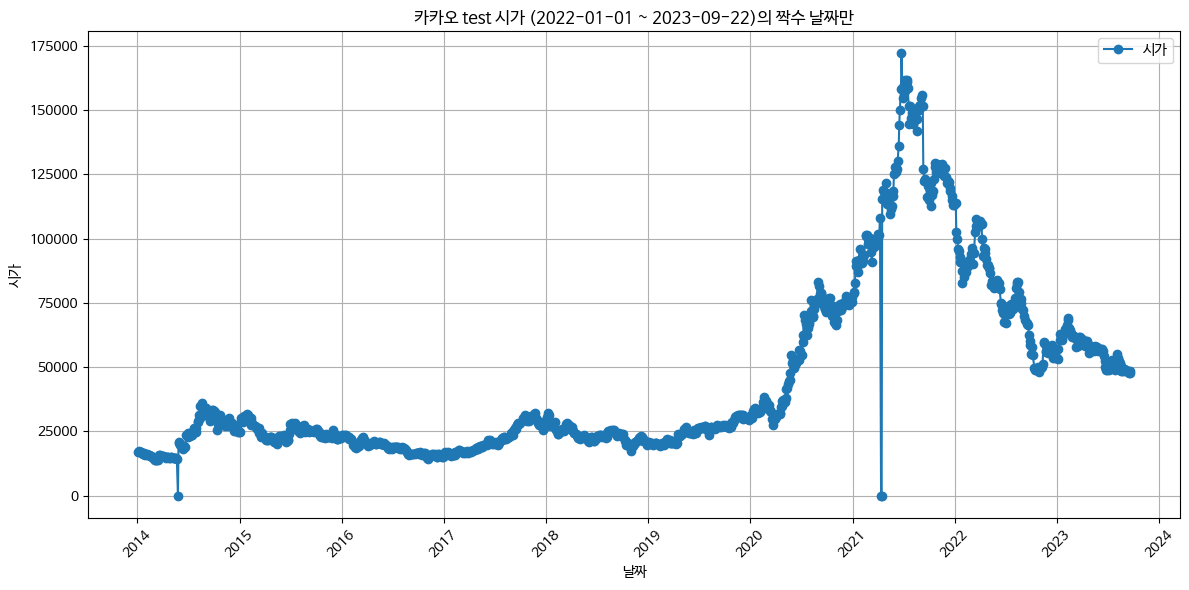

In [93]:
#랜덤 포레스트 모델 그래프
#test
plt.figure(figsize=(12, 6))
plt.plot(even_dates_data.index, even_dates_data['시가'], label='시가', marker='o', linestyle='-')
plt.xlabel('날짜')
plt.ylabel('시가')
plt.title('카카오 test 시가 (2022-01-01 ~ 2023-09-22)의 짝수 날짜만')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

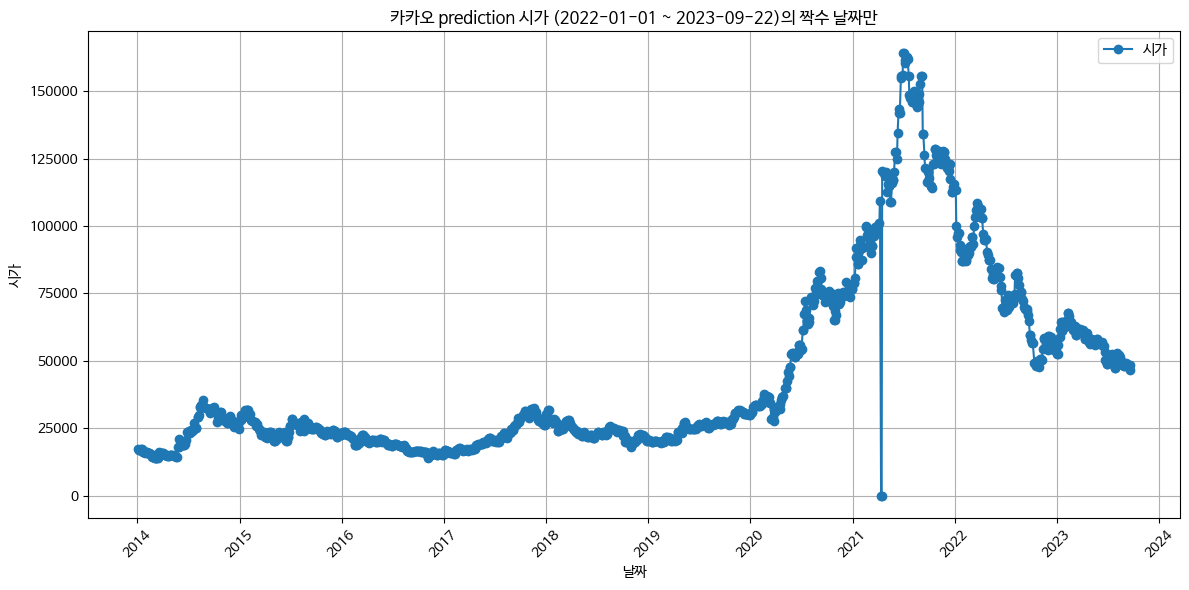

In [94]:
#랜덤 포레스트 모델 그래프
#predict
plt.figure(figsize=(12, 6))
plt.plot(even_dates_data.index, y_pred, label='시가', marker='o', linestyle='-')
plt.xlabel('날짜')
plt.ylabel('시가')
plt.title('카카오 prediction 시가 (2022-01-01 ~ 2023-09-22)의 짝수 날짜만')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [95]:
#시계열 데이터
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import t
ohlcv2['time'] = range(1, len(ohlcv2) + 1)
y = ohlcv2['시가']
X = ohlcv2['time']
X = sm.add_constant(X)

In [96]:
time = ohlcv2['time']
mean_t = time.mean()
mean_y = y.mean()
b1 = np.sum((y-mean_y)*(time-mean_t))/np.sum(np.square(time-mean_t))
b0 = mean_y-b1*mean_t
print(b1)
print(b0)

33.280589710061314
4503.817201668047


In [97]:
future = [1,2,3,4,5]
n = len(ohlcv2)
alpha = 0.05
X_tX_inv = np.linalg.inv(X.T.dot(X))
t_val = t.ppf(1-alpha/2,df=n-2)
 
predict_vals = []
upper_limit = []
lower_limit = []
for l in future:
    predict_val = b0+b1*(n+l)
    s2 = np.sum(np.square(y-b0-b1*time))/(n-2)
    x = np.array([[1],[n+l]])
    variance_factor = np.sqrt(1+x.T.dot(X_tX_inv.dot(x)))
    limit = t_val*np.sqrt(s2)*variance_factor[0][0]
    predict_vals.append(predict_val)
    upper_limit.append(predict_val+limit)
    lower_limit.append(predict_val-limit)

In [98]:
#결과 시각화
start_date = '2022-01-01'
 
pred_data = {
    'pred':predict_vals,
    'ul':upper_limit,
    'll':lower_limit
}
pred_df = pd.DataFrame(pred_data)

future_days=len(future)
pred_df.index = pd.date_range(start_date, periods=future_days ,freq='D')
 
fitted_val = b0+b1*time
vals = pd.concat([fitted_val,pred_df['pred']])

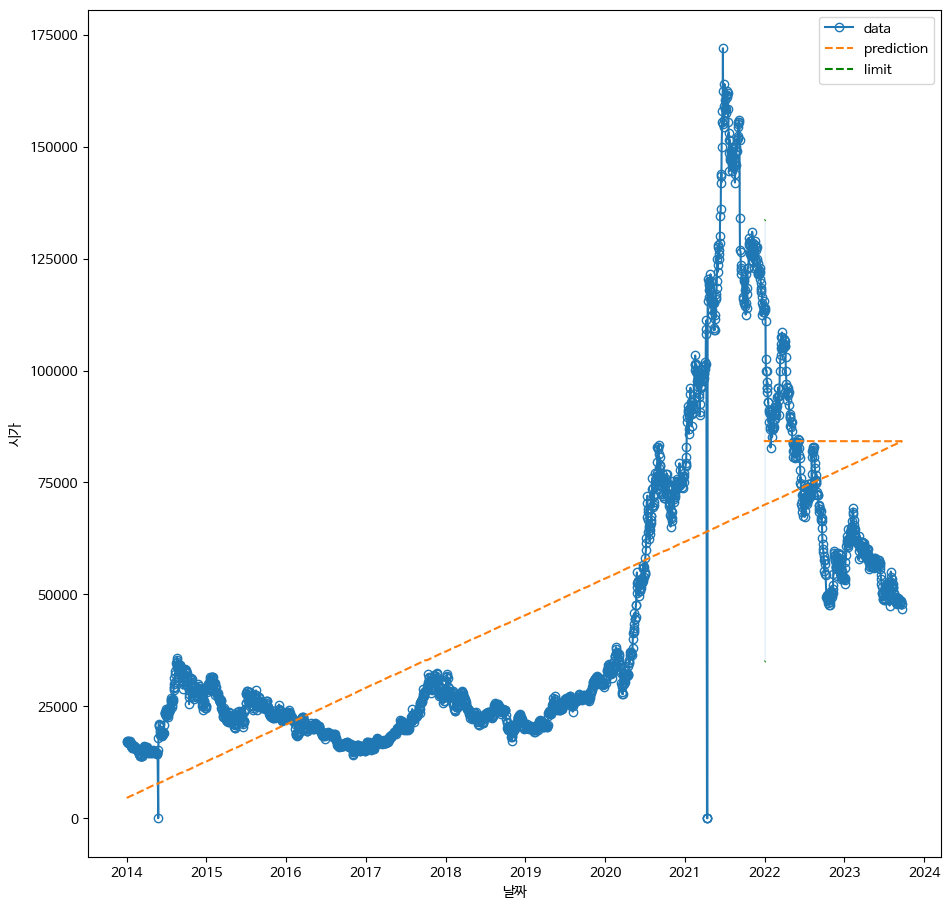

In [99]:
#시각화
fig = plt.figure(figsize=(11, 11))
fig.set_facecolor('white')

marker_config = dict()
marker_config['marker'] = 'o'
marker_config['markerfacecolor'] = 'none'
plt.plot(ohlcv2['시가'], label='data', **marker_config)
plt.plot(vals, label = 'prediction', linestyle='--')

plt.plot(pred_df['ll'], color = 'green', linestyle='--', label='limit')
plt.plot(pred_df['ul'], color = 'green', linestyle='--')
plt.fill_between(pred_df.index, pred_df['ll'], pred_df['ul'], alpha=0.2)
plt.legend(loc='upper right')
plt.ylabel('시가')
plt.xlabel('날짜')
plt.show()

In [100]:
#LSTM
#정규화 -> 모든 수치를 0과 1사이의 값으로
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#인스턴스 구축
scale_cols_for_X = ['시가', '고가', '저가', '거래량']
tests = scaler.fit_transform(odd_dates_data[scale_cols_for_X])
print(tests)

[[0.10487805 0.10117647 0.10496273 0.00081107]
 [0.10304268 0.10188824 0.10483851 0.00297396]
 [0.10390244 0.10117647 0.10334161 0.00316589]
 ...
 [0.29329268 0.28764706 0.29875776 0.09758854]
 [0.29634146 0.28647059 0.29689441 0.05707109]
 [0.28536585 0.27735294 0.28322981 0.14176406]]


In [101]:
#LSTM 훈련 데이터
scaler2 = MinMaxScaler() #x값을 위한 정규화 instance
scaler3 = MinMaxScaler() #y값을 위한 정규화 instance

#cols_all = ['시가', '고가', '저가', '거래량', '종가']
scale_cols_for_X = ['시가', '고가', '저가', '거래량']
scale_cols_for_y = ['종가']

tests = scaler2.fit_transform(ohlcv2[scale_cols_for_X])
tests2 = scaler3.fit_transform(ohlcv2[scale_cols_for_y])

X = np.array([tests[i:i+1] for i in range(tests.shape[0]-1)]) #3차원에서의 1리스트 크기 전용
y = np.array([tests[i+1] for i in range(tests2.shape[0]-1)]) #3차원에서의 1리스트 크기 전용
#LSTM 층을 이용할 것이므로 3차원 형태로 데이터를 구축한다

In [102]:
#LSTM 훈련 데이터와 검증 데이터 분리
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [103]:
#모델 구성
import tensorflow as tf
X_model_input = tf.keras.layers.Input(shape=(X.shape[1], X.shape[2]))

In [104]:
#LSTM적용
#정방향
X_model_output = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(X_model_input)
#양방향
# X_model_output = tf.keras.layers.Bidirectional(   tf.keras.layers.LSTM(16,return_sequences=True)   )(X_model_input) # 양방향 LSTM
# X_model_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(X_model_output) # 양방향 LSTM

In [105]:
#하나의 값 output(종가)하면서 나오기 떄문에 한개의 값이 나오게 한다
X_model_output = tf.keras.layers.Dense(1, activation = 'linear')(X_model_output)

In [106]:
X_model_output = tf.keras.layers.Dense(1)(X_model_output)

In [107]:
#Funtional_API_INPUT과 outputs를 정의하여 최종 모델 구축
result_model = tf.keras.Model(inputs=X_model_input, outputs=X_model_output)

#컴파일 및 훈련
result_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
result_model.fit(x_train, y_train, batch_size = 1, epochs=100, validation_data=(x_valid, y_valid), callbacks=[early_stop])


Epoch 1/100
1915/1915 [==============================] - 5s 2ms/step - loss: 0.0167 - acc: 0.0013 - val_loss: 0.0137 - val_acc: 0.0026
Epoch 2/100
1915/1915 [==============================] - 4s 2ms/step - loss: 0.0140 - acc: 0.0017 - val_loss: 0.0137 - val_acc: 0.0026
Epoch 3/100
1915/1915 [==============================] - 4s 2ms/step - loss: 0.0140 - acc: 0.0017 - val_loss: 0.0137 - val_acc: 0.0026
Epoch 4/100
1915/1915 [==============================] - 4s 2ms/step - loss: 0.0140 - acc: 0.0022 - val_loss: 0.0138 - val_acc: 0.0026


In [108]:
a = scaler2.transform([[45100,45650,44800,1395423]])

print(a)
test=result_model.predict(np.array([a]))
print(scaler3.inverse_transform(test))

[[0.2622093  0.26387283 0.27826087 0.07385086]]
1/1 [==============================] - 0s 206ms/step
[[46160.5]]
